In [1]:
import sys
import pathlib
path=pathlib.Path("../../../../robotics-course")
sys.path.append(str(path / 'build'))
import cv2 as cv
import numpy as np
import libry as ry
import time
import matplotlib.pyplot as plt

**ry-c++-log** ry.cpp:init_LogToPythonConsole:34(0) initializing ry log callback

**ry-c++-log** util.cpp:initCmdLine:545(1) ** cmd line arguments: 'rai-pybind -python '** INFO:ry.cpp:init_LogToPythonConsole:34(0) initializing ry log callback


**ry-c++-log** util.cpp:initCmdLine:549(1) ** run path: '/home/vasko/Documents/TUB3/AI_Robotics/robotics-course/course3-Simulation/04-opencv/solutions'** INFO:util.cpp:initCmdLine:545(1) ** cmd line arguments: 'rai-pybind -python '


**ry-c++-log** graph.cpp:initParameters:1379(1) ** parsed parameters:
{python}
** INFO:util.cpp:initCmdLine:549(1) ** run path: '/home/vasko/Documents/TUB3/AI_Robotics/robotics-course/course3-Simulation/04-opencv/solutions'


** INFO:graph.cpp:initParameters:1379(1) ** parsed parameters:
{python}



In [2]:
#-- Add REAL WORLD configuration and camera
RealWorld = ry.Config()
RealWorld.addFile(str(path / "scenarios/pandasTable.g"))
ballRef = RealWorld.addFrame("ballRef")
ballRef.setPosition([0,0.4,.8])

ball2 = RealWorld.addFrame("ball2",parent="ballRef",args="joint:transXY")
ball2.setShape(ry.ST.sphere, [0.05])
ball2.setColor([1,0,0])
ball2.setRelativePosition([-.3,0.,0.])

ball3 = RealWorld.addFrame("ball3",parent="ballRef",args="joint:transXY")
ball3.setShape(ry.ST.sphere, [0.05])
ball3.setColor([1,0,0])
ball3.setRelativePosition([.3,0.,0.])

ball = RealWorld.addFrame("ball",parent="ballRef",args="joint:transXY")
ball.setShape(ry.ST.sphere, [0.05])
ball.setColor([1,0,0])



In [3]:
S = RealWorld.simulation(ry.SimulatorEngine.bullet, True)

In [4]:
S.addSensor("camera")

In [5]:
def red_obj_det(image):
    result = image.copy()

    image_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    # lower boundary RED color range values; Hue (0 - 10)
    lower1 = np.array([0, 100, 20])
    upper1 = np.array([10, 255, 255])

    # upper boundary RED color range values; Hue (160 - 180)
    lower2 = np.array([160,100,20])
    upper2 = np.array([179,255,255])

    lower_mask = cv.inRange(image_hsv, lower1, upper1)
    upper_mask = cv.inRange(image_hsv, lower2, upper2)

    full_mask = lower_mask + upper_mask;

    result = cv.bitwise_and(result, result, mask=full_mask)

    mask_greyscale = np.repeat(full_mask[:,:,np.newaxis],3,axis=2)
    
    contours, hierarchy = cv.findContours(cv.cvtColor(mask_greyscale, cv.COLOR_RGB2GRAY),cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    
    return contours, full_mask



In [6]:
cameraFrame = RealWorld.frame("camera")
# camera = S.selectSensor("camera")
# camera
cameraFrame

In [7]:
# camera = S.selectSensor("camera")


In [8]:
cameraFrame = RealWorld.getFrame("camera")
# camera = S.selectSensor("camera")

f=0.895; W=640; H=360; #from the scenario file
                
fx, fy = f*H, f*H
px, py = W/2, H/2
R, off = cameraFrame.getRotationMatrix(), cameraFrame.getPosition()
R,off

(array([[ 1.       ,  0.       ,  0.       ],
        [ 0.       ,  0.8660254, -0.5      ],
        [ 0.       ,  0.5      ,  0.8660254]]),
 array([-0.01, -0.2 ,  1.8 ]))

In [9]:
pos = np.array([1,2,3])
m  = np.array(np.arange(9)).reshape(3,3)
print(m,pos)

[[0 1 2]
 [3 4 5]
 [6 7 8]] [1 2 3]


In [10]:
def pos_image_to_world(cameraFrame, x, y, Z):
## depth is sign-fliped, j: right, i: down

    ## Camera Frame
    pos = np.zeros(3)
    pos[0] = Z * (x - px) / fx;
    pos[1] = -Z * (y - py) / fy;
    pos[2] = -Z
    
    
    
    ## Coordinate transformation (from camera to world) 
    pos = (R@pos[:,np.newaxis]).flatten() + off
    
    return pos

In [11]:
def z_from_mask(depth, mask):
    return depth[mask!=0].mean()

In [35]:
o_depth = None
o_contour = None

In [47]:
def z_from_contour(depth, contour):
    global o_depth, o_contour
#     print("Third")
#     print(contour.dtype)
    o_depth = depth
    o_contour = contour
    c = contour.reshape(-1,2)
    return depth[c[:,1], c[:,0]].mean()

In [48]:
def estimateBallPosition(depth, contour):
#     print(contours)
#     Z_mean = z_from_mask(depth, full_mask)
#     print("Third")
#     print(contour.dtype)
    Z_mean = z_from_contour(depth, contour)
#     print("Pos Z: {}".format(Z_mean_b - Z_mean))
    
    M = cv.moments(contour)
#     print(M)
    if (M["m00"]):
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    
        pos = pos_image_to_world(cameraFrame, cX, cY, Z_mean)
    else:
        pos = np.zeros(3)
        print("Error: Ball not detected!")
    
    return pos 

In [49]:
# [rgb, depth] = S.getImageAndDepth()  #we don't need image
# pos = estimateBallPosition(rgb,depth)
# contours, full_mask = red_obj_det(rgb)
# c = contours[0].reshape(-1,2)
# depth[c[:,0], c[:,1]].mean()
# tmp = RealWorld.addFrame("pc")
# tmp.setShape(ry.ST.sphere, [0.01])
# tmp.setColor([255,0,5])
# #     tmp.setColor(rgb[i,j]/255)
# tmp.setPosition(pos.flatten())

In [50]:
tau = 1e-2
q = S.get_q()
w = .01
A = .3

tmp = RealWorld.addFrame("pc")
tmp.setShape(ry.ST.sphere, [0.05])
tmp.setColor([255,20,0,0.5])

prev_contours = None
prev_full_mask = None

for t in range(10000):

    #grab sensor readings from the simulation
    if t%10 == 0:
        [rgb, depth] = S.getImageAndDepth()  #we don't need images with 100Hz, rendering is slow
        
        contours, full_mask = red_obj_det(rgb)
        if (len(contours)!=0):
            solution = contours[0]
            print(depth.shape)

            if prev_contours != None:
                diff_mask = (full_mask - prev_full_mask).clip(0,255)

                for c in contours:
                    image_mask = cv.drawContours(np.zeros(full_mask.shape, np.uint8), [c], -1, 255, cv.FILLED)
                    combination_mask = cv.bitwise_and(diff_mask, image_mask)
                    if (np.count_nonzero(combination_mask)>20):
                        solution = c
                        break;
#             print("First")
#             print(solution.dtype)

            est_pos = estimateBallPosition(depth, solution)
            prev_contours, prev_full_mask = contours, full_mask
                    

    #     tmp.setColor(rgb[i,j]/255)
        tmp.setPosition(est_pos)
    
        gt_pos = ball.getPosition()
        err = np.linalg.norm(est_pos-gt_pos)        
        print("Error: ", err)
#         time.sleep(2)

    q[-2] = A * (np.cos(w*t) - 1)
    q[-1] = A * np.sin(w*t)
    
    S.step(q, tau, ry.ControlMode.position)
    time.sleep(tau)

(360, 640)
Error:  0.7886252055858181
(360, 640)
Error:  0.013371803928828557
(360, 640)
Error:  0.014001545970906247
(360, 640)
Error:  0.01392924297355683
(360, 640)
Error:  0.013220562574330783
(360, 640)
Error:  0.013769455055694848
(360, 640)
Error:  0.014328297128201927
(360, 640)
Error:  0.013585930187853932
(360, 640)
Error:  0.013931238333971974
(360, 640)
Error:  0.01316331122235823
(360, 640)
Error:  0.012749912245159424
(360, 640)
Error:  0.01404153454491326
(360, 640)
Error:  0.013623604834728305
(360, 640)
Error:  0.01341884759380098
(360, 640)
Error:  0.013671471449800222
(360, 640)
Error:  0.012853963708951425
(360, 640)
Error:  0.012008876251369236
(360, 640)
Error:  0.013572665101416031
(360, 640)
Error:  0.012213515914180928
(360, 640)
Error:  0.012980407243226187
(360, 640)
Error:  0.012990890146456949
(360, 640)
Error:  0.01307093710058038
(360, 640)
Error:  0.01239905495701654
(360, 640)
Error:  0.012167467723546377
(360, 640)
Error:  0.011571208300610066
(360, 64

(360, 640)
Error:  0.01264396137922333
(360, 640)
Error:  0.013033544484982498
(360, 640)
Error:  0.013377903526095938
(360, 640)
Error:  0.012578440999914278
(360, 640)
Error:  0.012203846979279757
(360, 640)
Error:  0.012062646199212304
(360, 640)
Error:  0.011840236279146451
(360, 640)
Error:  0.011941166865349953
(360, 640)
Error:  0.01151221581458083
(360, 640)
Error:  0.011134731080409724
(360, 640)
Error:  0.011516231037872983
(360, 640)
Error:  0.012027983730275454
(360, 640)
Error:  0.012099800488831029
(360, 640)
Error:  0.011573813032044068
(360, 640)
Error:  0.010810636307149563
(360, 640)
Error:  0.011192928336295042
(360, 640)
Error:  0.010228042763104822
(360, 640)
Error:  0.010602289520888448
(360, 640)
Error:  0.010663977437998016
(360, 640)
Error:  0.010821684029564587
(360, 640)
Error:  0.010546252493610134
(360, 640)
Error:  0.00993007187206356
(360, 640)
Error:  0.010609866060916542
(360, 640)
Error:  0.011092199820559452
(360, 640)
Error:  0.011157041464832642
(36

(360, 640)
Error:  0.012592279770505201
(360, 640)
Error:  0.012101652901993906
(360, 640)
Error:  0.010222892048284806
(360, 640)
Error:  0.009929331203376754
(360, 640)
Error:  0.011187052142740659
(360, 640)
Error:  0.011079664723469353
(360, 640)
Error:  0.011059814687897377
(360, 640)
Error:  0.010857548067234976
(360, 640)
Error:  0.010917430110630804
(360, 640)
Error:  0.011181736644255416
(360, 640)
Error:  0.012468155550671019
(360, 640)
Error:  0.012522043147467628
(360, 640)
Error:  0.011625501949641489
(360, 640)
Error:  0.012526846278989852
(360, 640)
Error:  0.012580145864075245
(360, 640)
Error:  0.012282212393380891
(360, 640)
Error:  0.013335977697007432
(360, 640)
Error:  0.013326230289174767
(360, 640)
Error:  0.013343552892375592
(360, 640)
Error:  0.013132317194498621
(360, 640)
Error:  0.013444575851908655
(360, 640)
Error:  0.013394265918377583
(360, 640)
Error:  0.013273359996494167
(360, 640)
Error:  0.013013023580254312
(360, 640)
Error:  0.012937187106524611


(360, 640)
Error:  0.012896068507201167
(360, 640)
Error:  0.013172453297478322
(360, 640)
Error:  0.012130873720624123
(360, 640)
Error:  0.012859516549458102
(360, 640)
Error:  0.012113438576280432
(360, 640)
Error:  0.013158056189740624
(360, 640)
Error:  0.013852407764648068
(360, 640)
Error:  0.012177818371037069
(360, 640)
Error:  0.012529117458588585
(360, 640)
Error:  0.012447464111703973
(360, 640)
Error:  0.012607765695848172
(360, 640)
Error:  0.01352609167232684
(360, 640)
Error:  0.012773644585580501
(360, 640)
Error:  0.01346257438863854
(360, 640)
Error:  0.013668139365387764
(360, 640)
Error:  0.013101600584828954
(360, 640)
Error:  0.01297780971535851
(360, 640)
Error:  0.014096547575188571
(360, 640)
Error:  0.012014651289366367
(360, 640)
Error:  0.013543620776879695
(360, 640)
Error:  0.013423388499963159
(360, 640)
Error:  0.013531642362470056
(360, 640)
Error:  0.013072975878525007
(360, 640)
Error:  0.013441043052652757
(360, 640)
Error:  0.013435674871805938
(36

(360, 640)
Error:  0.01276299322777176
(360, 640)
Error:  0.014072322218956197
(360, 640)
Error:  0.012495942968980935
(360, 640)
Error:  0.01301019385310865
(360, 640)
Error:  0.013019047796333793
(360, 640)
Error:  0.01250821241953778
(360, 640)
Error:  0.013170426993936722
(360, 640)
Error:  0.013172421560265966
(360, 640)
Error:  0.012886740856040968
(360, 640)
Error:  0.012394049905303232
(360, 640)
Error:  0.012969933076110303
(360, 640)
Error:  0.013819438990840545
(360, 640)
Error:  0.012784485734231684
(360, 640)
Error:  0.012627699146673343
(360, 640)
Error:  0.011729266472907517
(360, 640)
Error:  0.012706244467245156
(360, 640)
Error:  0.012898742860362031
(360, 640)
Error:  0.012865495072108612
(360, 640)
Error:  0.01123951455714714
(360, 640)
Error:  0.011582850748544498
(360, 640)
Error:  0.01144896650655082
(360, 640)
Error:  0.012050730561017475
(360, 640)
Error:  0.011532335101294207
(360, 640)
Error:  0.010710126611600564
(360, 640)
Error:  0.011376745780237278
(360,

## Debugging the code


In [25]:
for _ in range(10):
    t+=1
    q[-2] = A * (np.cos(w*t) - 1)
    q[-1] = A * np.sin(w*t)
    S.step(q, tau, ry.ControlMode.position)
    time.sleep(tau)

In [26]:
#grab sensor readings from the simulation
if (t!=0) :
    [rgb, depth] = S.getImageAndDepth()  #we don't need images with 100Hz, rendering is slow

    contours, full_mask = red_obj_det(rgb)
    if prev_contours == None:
        prev_contours, prev_full_mask = contours, full_mask
        if (len(contours)!=0):
            est_pos = estimateBallPosition(depth, contours[0])
    else:
        diff_mask = (full_mask - prev_full_mask).clip(0,255)
        for i,c in enumerate(contours):
            image_mask = cv.drawContours(np.zeros(full_mask.shape, np.uint8), [c], -1, 255, cv.FILLED)
            combination_mask = cv.bitwise_and(diff_mask, image_mask)
            if (np.count_nonzero(combination_mask)>20):
                solution = c
                print("Contour number {}".format(i))
                break;
                
        print("Estimating position")        
        est_pos = estimateBallPosition(depth, contour)
        prev_contours, prev_full_mask = contours, full_mask




#     tmp.setColor(rgb[i,j]/255)
    tmp.setPosition(est_pos)

    gt_pos = ball.getPosition()
    err = np.linalg.norm(est_pos-gt_pos)        
    print("Error: ", err)


Contour number 2
Estimating position
Error:  0.8331079409454978


In [21]:
image_mask = cv.drawContours(np.zeros(full_mask.shape, np.uint8), [contours[2]], -1, 255, cv.FILLED)
combination_mask = cv.bitwise_and(diff_mask, image_mask)
print(combination_mask.shape)
print(combination_mask)
print(combination_mask[combination_mask!=0])

(360, 640)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
np.count_nonzero(combination_mask)

192

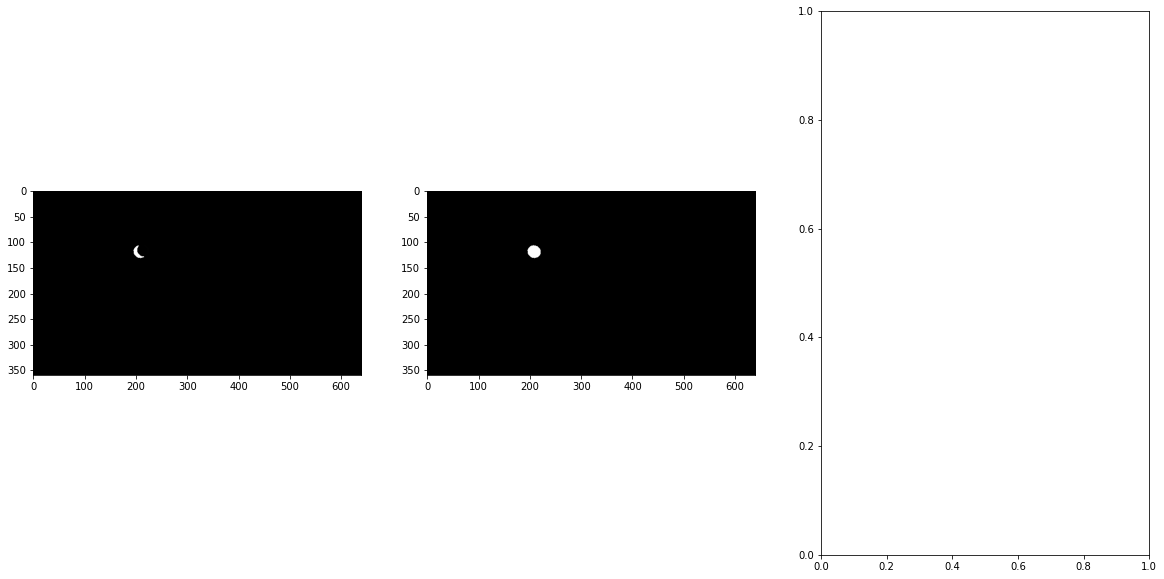

In [23]:
mask_greyscale_diff = np.repeat(diff_mask[:,:,np.newaxis],3,axis=2)
mask_greyscale_image = np.repeat(image_mask[:,:,np.newaxis],3,axis=2)
fig = plt.figure(figsize=(20,10))
axs = fig.subplots(1, 3)

axs[0].imshow(mask_greyscale_diff)
axs[1].imshow(mask_greyscale_image)
# axs[2].imshow(result)
plt.show()